# Data format (input/output data)

In this project, we mainly deal with two types of data format:

* Waveform: 16/32-bit PCM or 32-bit float WAV that can be read by [scipy.io.wavfile.read](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html)

* Binary data: binary, float-32bit, little endian ([numpy dtype <f4](https://numpy.org/doc/1.18/reference/generated/numpy.dtype.html)) 

![Iamges_c1_1](./figures/fig_c1_1.png)

As figures above shows, the data saved in the file system will be read in as Numpy array (float32), after which it will be further converted to Pytorch tensor.

In this notebook, we focus on the conversion between raw data and Numpy array.

For waveform data, users don't need to check the details of the Python data I/O. Just for information, these are the functions to [read](https://github.com/nii-yamagishilab/project-NN-Pytorch-scripts/blob/8c8318612e467c61c9d7d9315714e522bce3f2fe/core_scripts/data_io/wav_tools.py#L103) and [write](https://github.com/nii-yamagishilab/project-NN-Pytorch-scripts/blob/8c8318612e467c61c9d7d9315714e522bce3f2fe/core_scripts/data_io/wav_tools.py#L126) the waveform data. They are just simple wrappers over scipy.io.wavfile. 


### 1. Write binary data

We use Numpy interface to write and read binary data. 

Let's first create a numpy array and write to an external file

In [1]:
import numpy as np

data = np.asarray([[1, 2, 3],[4, 5, 6],[7, 8, 9],[10, 11, 12],[13, 14, 15]], dtype=np.float32)
f = open('data_models/temp_data.bin','wb')
datatype = np.dtype('<f4')
data.astype(datatype).tofile(f,'')
f.close()

print(data)

[[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]
 [13. 14. 15.]]


### 2. Read binary data
Now we can read data using numpy

In [2]:
f = open('data_models/temp_data.bin','rb')
datatype = np.dtype('<f4')
data_read = np.fromfile(f,dtype=datatype)
f.close()
print(data_read)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


Notice that the data shape is no longer in \[5, 3\]

Also notice that we normally use [c_continuous format](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flags.html) (row-major) when storing the data in external file.


In [3]:
data.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In other words, the data is stored in this order: data\[0, 0\], data\[0, 1\], data\[0, 2\], data\[1, 0\], data\[1, 1\], data\[1, 2\] ...

Therefore, to recover the original shape of data matrix, we need to know how many columns the original data matrix has. 

In [4]:
f = open('data_models/temp_data.bin','rb')

# the data has three columns
col_num = 3
datatype = np.dtype(('<f4', (col_num, )))

data_read = np.fromfile(f,dtype=datatype)
f.close()
print(data_read)

[[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]
 [13. 14. 15.]]


Based on the example above, we provide wrapper functions over numpy API to read and write binary data. 

See this [reader function](https://github.com/nii-yamagishilab/project-NN-Pytorch-scripts/blob/8c8318612e467c61c9d7d9315714e522bce3f2fe/core_scripts/data_io/io_tools.py#L19) and [writer function](https://github.com/nii-yamagishilab/project-NN-Pytorch-scripts/blob/8c8318612e467c61c9d7d9315714e522bce3f2fe/core_scripts/data_io/io_tools.py#L143) in the Pytorch scripts.

For convenience, we also put the two functions in ./tool_lib.py:
* reader function: data = tool_lib.read_raw_mat(data_file_path, number_of_column)
* write function: tool_lib.write_raw_mat(data, data_file_path)



You will see examples of using these two functions next.

### 3. Read some real speech data

Here I use read_raw_mat in tool_lib.py to read a Mel-spectrogram file and an F0 file.

Text(0.5, 1.0, '100th frame of Mel-spectrogram')

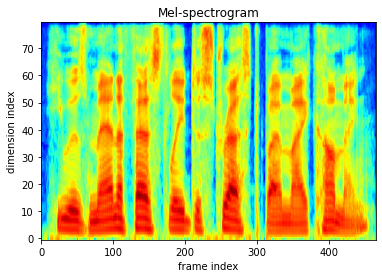

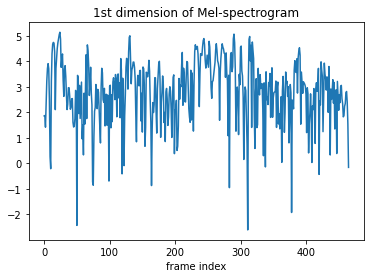

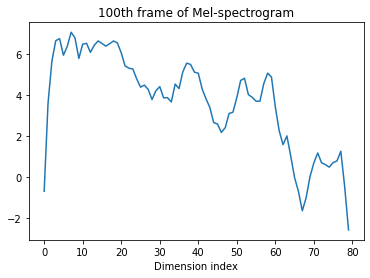

In [5]:
import tool_lib
import matplotlib
import matplotlib.pyplot as plt

# the mel-spectrogram data matrix has 80 columns
# column corresponds to dimension
# row corresponds to frame
mel_dimension = 80
mel_data = tool_lib.read_raw_mat('data_models/acoustic_features/hn_nsf/bdl_arctic_b0474.mfbsp', mel_dimension)

fig = plt.figure()
axis = fig.add_subplot(111)
axis.imshow(mel_data.T, aspect='auto', origin='lower', cmap='jet')
axis.set_xlabel("frame index")
axis.set_ylabel("dimension index")
axis.set_title("Mel-spectrogram")

# plot the 1st dimension of Mel-spectrogram
fig = plt.figure()
axis = fig.add_subplot(111)
axis.plot(mel_data[:, 0])
axis.set_xlabel("frame index")
axis.set_title("1st dimension of Mel-spectrogram")

# plot the 100th frame of Mel-spectrogram
fig = plt.figure()
axis = fig.add_subplot(111)
axis.plot(mel_data[100-1, :])
axis.set_xlabel("Dimension index")
axis.set_title("100th frame of Mel-spectrogram")

Text(0.5, 1.0, 'F0 trajectory')

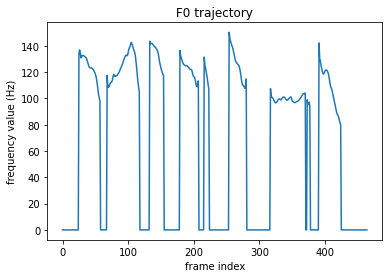

In [6]:
# example of reading F0
f0_dimension = 1
f0_data = tool_lib.read_raw_mat('data_models/acoustic_features/hn_nsf/bdl_arctic_b0474.f0', f0_dimension)

fig = plt.figure()
axis = fig.add_subplot(111)
axis.plot(f0_data)
axis.set_xlabel("frame index")
axis.set_ylabel("frequency value (Hz)")
axis.set_title("F0 trajectory")

In [7]:
print("Mel-spectrogram data shape" + str(mel_data.shape))
print("F0 data shape" + str(f0_data.shape))

Mel-spectrogram data shape(466, 80)
F0 data shape(465,)


Notice that mel_data has shape (466, 80), where 466 denotes the number of frames and 80 denotes the feature dimension in each frame.

Notice that f0_data has shape (465,), where 465 denotes the number of frames.


The above examples shows the conventions for data reading and writing: 

1. 2D data is in shape \[N, M\], where N denotes the frame number and M denotes the feature dimension in each frame

2. 1D data is in shape \[N\], where N denotes the frame number

In practice, please just use the read_raw_mat and write_raw_mat to read and write binary data

### 4. Number of frames

In previous examples, the Mel-spectrogram has 466 frames while the F0 has 465 frames. This difference is mainly caused by the tools extracting Mel-spectrogram and F0. 

In this Pytorch script, the [default data loader](https://github.com/nii-yamagishilab/project-NN-Pytorch-scripts/blob/8c8318612e467c61c9d7d9315714e522bce3f2fe/core_scripts/data_io/default_data_io.py) will handle the mis-match of the frame number. No need to worry about it.

### 5. Summary

In summary, we assume the following conventions:

1. raw data is saved as binary, float32, little-endian format
2. raw data is read as c-continuous (row-major) matrix
3. raw data in shape [N, M], where N denotes number of frames / time steps, and M denotes feature dimension per time step
4. raw data in shape [N], if M=1

The end